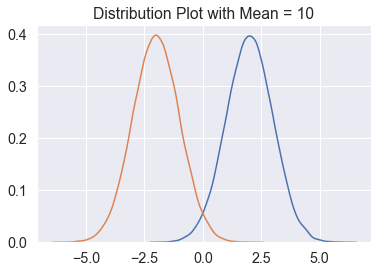

In [1]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False)
sns.distplot(list(zip(*class_neg_one))[0], hist=False)
plt.title("Distribution Plot with Mean = 10")
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def CART_estimate_posterior(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    neg_one_class, one_class = np.hsplit(probs, 2)
    return X, neg_one_class, one_class

In [4]:
def honesty_estimate_posterior(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    neg_one_class, one_class = np.hsplit(probs, 2)
    return X, neg_one_class, one_class

In [5]:
def cef_estimate_posterior(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    neg_one_class, one_class = np.hsplit(probs, 2)
    return X, neg_one_class, one_class

# Run multiple trials

In [6]:
from tqdm import tqdm_notebook

def get_posteriors_variance(n, mean, trials):
    honest_one = []
    cef_one = []
    cart_one = []
    X_samples = []
    for i in tqdm_notebook(range(trials)):
        X, y = get_sample(n, mean, 1)
        X = np.array(X).reshape(-1, 1)
        X_samples.append(X)
        X_labels, neg_one_cart, one_cart = CART_estimate_posterior(X, y, 300, .32)
        X_labels, neg_one_honest, one_honest = honesty_estimate_posterior(X, y, 300, .32)
        X_labels, neg_one_cef, one_cef = cef_estimate_posterior(X, y, 300, .32)
        honest_one.append(one_honest)
        cef_one.append(one_cef)
        cart_one.append(one_cart)
        
    return X_samples, cart_one, honest_one, cef_one


In [ ]:
# Run 500 trials
## THIS CODE TAKES A LONG TIME TO RUN
X_samples, cart_one, honest_one, cef_one = get_posteriors_variance(5000, 1, 500)

# PLOT

In [ ]:
sns.set(font_scale = 6)
sns.set_style("ticks")
indices = np.sort(np.random.choice(5000, 100, replace = False))

plt.rcParams['figure.figsize'] = [55, 14]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
for i in range(0, 5):
    linewidth = 1
    alpha = .3
    if i == 4:
        alpha = 1
        linewidth = 4
    line_cart, = ax1.plot(np.sort(X_samples[i].flatten())[indices], cart_one[i][indices], label = "CART", linewidth = linewidth, color = "#1b9e77", alpha = alpha)
    line_honest, = ax2.plot(np.sort(X_samples[i].flatten())[indices], honest_one[i][indices], label = "Honesty", linewidth = linewidth, color = "#fdae61", alpha = alpha)
    line_cef, = ax3.plot(np.sort(X_samples[i].flatten())[indices], cef_one[i][indices], label = "CF", linewidth = linewidth, color = "#F41711", alpha = alpha)
indices = np.sort(np.random.choice(5000, 500, replace = False))

ax1.set_title("CART Forests")
ax2.set_title("Honest Forests")
ax3.set_title("Uncertainty Forests")

line_cef_var, = ax4.plot(avg_X_samples[indices], var_cef_one.flatten()[indices], label = "CF", linewidth = 4, color = "#F41711")

line_cart_var, = ax4.plot(avg_X_samples[indices], var_cart_one.flatten()[indices], label = "CART", linewidth = 4, color = "#35978f")

line_honest_var, = ax4.plot(avg_X_samples[indices], var_honest_one.flatten()[indices], label = "Honesty", linewidth = 4, color = "#fdae61")
#plt.legend(handles=[line_cart, line_honest, line_cef,], loc = 'upper right')
#fig.text(0.5, -.03, 'Magnitude of X', ha='center')
fig.text(0.5, .08, 'Magnitude of X', ha='center')
ax1.set_ylabel(r"$\hat P(Y = 1|X = x)$")
ax4.set_ylabel(r"$\hat P(Y|X = x)$ Variance")
ax1.set_xlabel(" ")
ax4.set_xlim(-2.5, 2.5)
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
fig.tight_layout()
plt.savefig("posterior_combined_and_var_f19.pdf")
plt.show()